Bloom Timing - Updated for 2023
==

Look at potential environmental factors contributing to the initiation
of the bloom.

* Tidal velocity, tidal phasing relative to insolation, winds
* How anomalous are the conditions that permitted the bloom?
* Consider anomaly with respect to previous weeks, months, and prior summers.

2023-09 update:
* probably okay to use synthetic insolation
* would be compelling to show summer 2024, 2025
* show time series July 1 - Sep 15 or something... not so much the distributions.
* 

In [1]:
import sys
sys.path.append("/richmondvol1/rusty/stompy")

In [11]:
!conda list widget


# packages in environment at /opt/anaconda3:
#
# Name                    Version                   Build  Channel
ipywidgets                8.0.4            py38h06a4308_0  
jupyterlab_widgets        3.0.5            py38h06a4308_0  
widgetsnbextension        4.0.5            py38h06a4308_0  


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from stompy.io.local import noaa_coops
from stompy import utils,filters
import datetime
from stompy.io.local import cimis

import xarray as xr
%matplotlib widget

ModuleNotFoundError: No module named 'ipympl'

In [166]:
# Common time periods:
window_of_opportunity=np.timedelta64(5,'D') #care about conditions averaged over 5 days.
bloom2022_start = np.datetime64("2022-08-08") # center of the window
bloom2023_start = np.datetime64("2023-07-26") # guessing 

In [167]:
def boxcar(da):
    return filters.lowpass_fir(da,window_of_opportunity,window='boxcar')

    
utc2pst=np.timedelta64(-8,'h')


Tides
==

In [169]:
# Get a longish period of data at Alameda, including tidal predictions
import six
six.moves.reload_module(noaa_coops)
noaa_alameda=noaa_coops.coops_dataset(9414750,
                                      #np.datetime64("1980-01-01"),
                                      np.datetime64("1996-01-01"), # Start of wind data.
                                      np.datetime64("2023-10-01"),
                                      ['water_level','predictions','wind','water_temperature','air_temperature'],
                                      cache_dir='cache',days_per_request="M",
                                      refetch_incomplete=True)

In [170]:
resample_dt=np.timedelta64(900,'s')

In [171]:
def resample(ds,dt):
    #delegating to pandas is surprisingly slow and ornery.
    #noaa_alameda.resample({'time':'360s'}).mean()

    t_new = np.arange(ds.time.values.min(), 
                      ds.time.values.max(),
                      dt)
    ds_resample = xr.Dataset()
    ds_resample['time']=('time',),t_new

    if 0: # pandas. slow.
        freq=f"{dt/np.timedelta64(1,'s'):.0f}s"
        for col in ds.data_vars:
            print(col)
            if 'time' not in ds[col].dims:
                ds_resample[col] = ds[col].copy() # don't share data
                continue
            # how bad is it to batch off to pandas? this is super slow.
            resampled=ds[col].to_dataframe().resample(freq).mean()
            ds_resample[col]= ds[col].dims, resampled[col].values
    else:
        bins = utils.nearest(t_new, ds.time.values)
        for col in ds.data_vars:
            if 'time' not in ds[col].dims:
                ds_resample[col] = ds[col].copy() # don't share data
                continue
            if not np.issubdtype(ds[col].dtype,np.number):
                print("Skipping non-numeric column ", col)
                continue
            values=ds[col].values
            valid=np.isfinite(values)
            values=np.where(valid,values,0.0)
            data_sum = np.bincount(bins, weights=values)
            data_count = np.bincount(bins, weights=1*valid)
            resampled=data_sum / data_count.clip(1)
            resampled[data_count==0]=np.nan
            ds_resample[col]= ds[col].dims, resampled
        
    return ds_resample

alameda_regular=resample(noaa_alameda.isel(station=0),resample_dt)


In [172]:
alameda_regular['water_level_filled'] = alameda_regular['water_level'].combine_first(alameda_regular['predictions'])

In [173]:
def central_difference(da):
    diff = 0*da
    t=da.time.values
    unit=np.timedelta64(3600,'s')
    diff.values[1:-1] = (da.values[2:] - da.values[:-2]) / ((t[2:] - t[:-2])/unit)
    diff.values[0] = diff.values[1]
    diff.values[-1] = diff.values[-2]
    return diff

alameda_regular['wse_t'] = central_difference(alameda_regular['water_level_filled'])



In [174]:
# Insolation

# Check that synthetic and CIMIS solar radiation are consistent.
cimisA=xr.open_dataset("/richmondvol1/hpcshared/inputs/cimis/union_city-hourly-2001-2016.nc")
#union_city-hourly-2022_bloom.nc

cimisA=cimisA.set_coords('time').swap_dims({'Date':'time'})
cimisA['time']=cimisA['time']+np.timedelta64(8,'h') # to UTC

CIMIS_KEY="2cbd0eea-39b0-4e5d-9f05-f9bf1fd2e90d"

cimisB=cimis.cimis_fetch_to_xr(stations=[171],
                               start_date=np.datetime64("2019-01-01"),
                               end_date = np.datetime64("2023-08-11"),
                               cache_dir='cache',
                               cimis_key=CIMIS_KEY)

cimisB['time']=cimisB['time']+np.timedelta64(8,'h') # to UTC

cimisBslice=cimisB.isel( time=cimisB.time.values>cimisA.time.values[-1])
cimis_data = xr.concat([cimisA.drop('Date'),cimisBslice],dim='time')

bad = cimis_data.HlySolRad.values<0
cimis_data.HlySolRad.values[bad]=np.nan

# dump that in with the other data
alameda_regular['cimis_rad']=('time',), utils.interp_near(alameda_regular.time,
                                               cimis_data.time.values, cimis_data.HlySolRad.values,
                                               max_dx=np.timedelta64(2,'h'))

alameda_regular['ideal_rad']=utils.ideal_solar_rad(alameda_regular.time)['sol_rad']

alameda_regular['rad_filled']=alameda_regular['cimis_rad'].combine_first(alameda_regular['ideal_rad'])

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

Summarizing tidal information
--

RMS tide is a simple spring-neap indicator. 

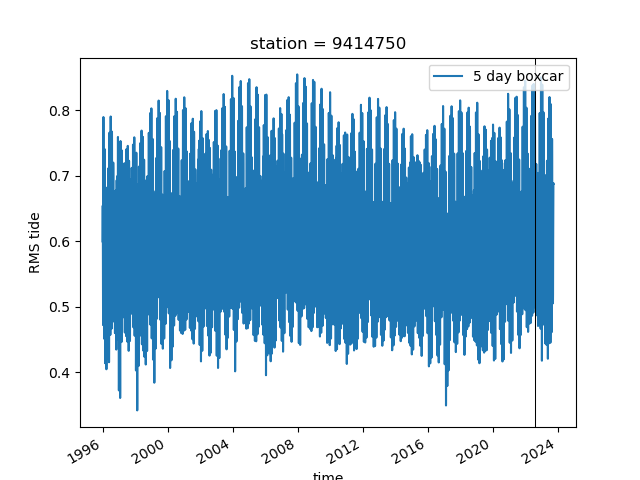

In [175]:
from stompy import filters
wse=alameda_regular.water_level_filled
        
def lp(x):
    return filters.lowpass_fir(x,winsize=np.timedelta64(60,'h'))
rms_tide=lp( (wse - lp(wse))**2 ) ** 0.5
rms_tide.name="RMS tide"                             

fig,ax=plt.subplots()

#wse.plot(label="WSE")
#rms_tide.plot(label="RMS tide")
agg_metric=filters.lowpass_fir(rms_tide,winsize=np.timedelta64(5,'D'),window='boxcar')
agg_metric.plot(label='5 day boxcar')

ax.legend(loc='upper right')
ax.axvline(bloom2022_start,color='k',lw=0.75)

In [176]:
# For a given metric, plot some date ranges, and compare time of bloom
# to overall distribution
window=window_of_opportunity
time_res=np.timedelta64(1,'D')

def yearly_sel(t,min_doy,max_doy):
    doy=(t - t.astype('M8[Y]'))/np.timedelta64(1,'D')
    return (doy>=min_doy)&(doy<max_doy)

periods2022=[ 
    #dict(name='previous month',
    #     label='prevmonth',
    #     pred=lambda t: (t>=np.datetime64("2022-07-10")) & (t<np.datetime64("2022-08-10"))),
    dict(name='Previous 2 months',
         label='prev2months',
         pred=lambda t: (t>=np.datetime64("2022-06-10")) & (t<np.datetime64("2022-08-10"))),
    dict(name='July-Aug yearly',
         label='all_july_aug',
         pred=lambda t: yearly_sel(t,181,243) # July 1 to Aug 31, +-leap day 
        ),
]
periods2023=[ 
    dict(name='July-Aug 2023',
         label='prev2months',
         pred=lambda t: (t>=np.datetime64("2023-07-01")) & (t<np.datetime64("2023-08-31"))),
    dict(name='July-Aug yearly',
         label='all_july_aug',
         pred=lambda t: yearly_sel(t,181,243) # July 1 to Aug 31, +-leap day 
        ),
]


def metric_cdfs(metric_da,window=window_of_opportunity,
                time_res=np.timedelta64(1,'D'),
                bloom_start=np.datetime64("2022-08-04"),
                show_unfiltered=False,
                periods=periods2022):
    """
    Plot univariate distributions of the given metric, averaged over
    window-of-opportunity (boxcar), and show where the bloom period
    falls within the distributions, for multiple periods.
    
    metric_da is expected to have a meaningful name.
    show_unfiltered: also plot the metric before any averaging.
    return a list of figures corresponding to the periods.
    """
    if isinstance(metric_da,tuple):
        metric_da1,metric_da2,join = metric_da
        metric_da=join(metric_da1,metric_da2)
    else:
        metric_da1=metric_da2=None
        
    # aggregate over window of opportunity:
    metric = metric_da.values
    agg_metric = filters.lowpass_fir(metric_da,window,window='boxcar')
    agg_metric.name = metric_da.name+", 5d boxcar"
    stride=int(time_res/ np.median(np.diff(agg_metric.time)))
    agg_metric = agg_metric.isel(time=slice(None,None,stride))
    
    sample=agg_metric.sel(time=bloom_start, method='nearest')
        
    t=agg_metric.time.values
    fig,axss=plt.subplots(len(periods),2,figsize=(8,1. + 2.5*len(periods)))
    for row,(axs,period) in enumerate(zip(axss,periods)):
        sel=period['pred'](t)
        period_metric=agg_metric.isel(time=sel)
        period_samples = period_metric.values
        period_samples=period_samples[ np.isfinite(period_samples) ]
        period_samples = np.sort(period_samples)
        rank=np.searchsorted(period_samples,sample)
        pctile=100*rank/len(period_samples)
        
        print(f"{period['name']}: {pctile:.1f} percentile")
        
        axs[0].plot(agg_metric.time, agg_metric,color='0.6',lw=0.75,label=agg_metric.name)
        axs[0].plot(agg_metric.time, np.where(sel,agg_metric.values,np.nan),label='Comparison period')
        axs[0].axvline(bloom_start,color='k',lw=0.8,label=utils.strftime(bloom_start,"%Y-%m-%d"))
        if show_unfiltered:
            axs[0].plot(metric_da.time, metric_da, color='0.8',lw=0.5,alpha=0.5,zorder=-1,
                       label=metric_da.name)
        
        axs[1].hist( period_samples, bins=20)
        axs[1].axvline(sample,color='k',lw=0.8)
        if row+1==len(periods):
            axs[1].set_xlabel('Period metric')
        label=metric_da.name
        #period_str=period['name']
        axs[1].set_title(f"{label}, {period['name']}\n{pctile:.1f} percentile",fontsize=9)
        # ha='right',va='top',transform=axs[1].transAxes)

        t_range=[period_metric.time.min(),
                 period_metric.time.max()]
        pad=0.08*(t_range[1]-t_range[0])
        axs[0].axis( xmin=t_range[0]-pad,xmax=t_range[1]+pad)
        if row==0:
            axs[0].legend(loc='lower left',bbox_to_anchor=(-0.2,1.02),frameon=0,ncol=2)
        plt.setp(axs[0].get_xticklabels(), rotation=30, ha='right')
    fig.subplots_adjust(top=0.9,right=0.97,bottom=0.1,hspace=0.3)
        
    return fig
        

Previous 2 months: 3.3 percentile
July-Aug yearly: 13.8 percentile
July-Aug 2023: 0.0 percentile
July-Aug yearly: 2.5 percentile


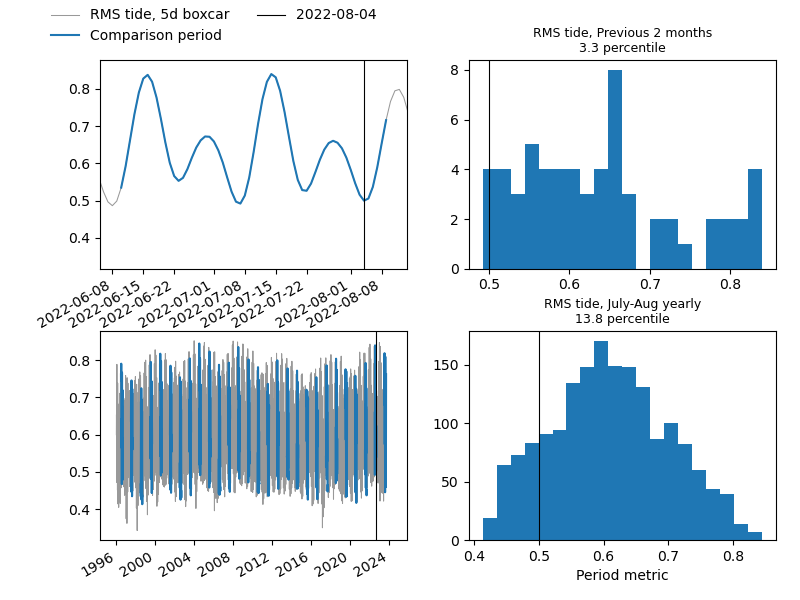

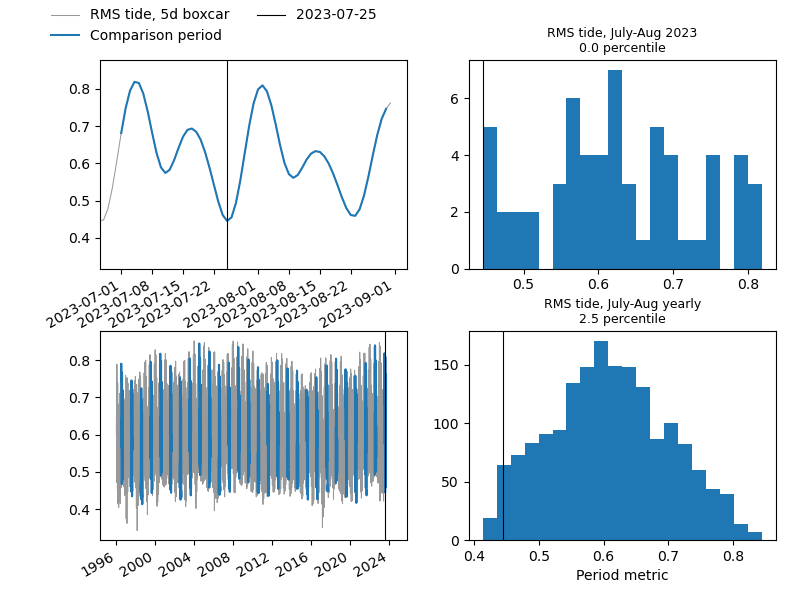

In [62]:
metric_cdfs(rms_tide, bloom_start=np.datetime64("2022-08-04"),periods=periods2022)
metric_cdfs(rms_tide, bloom_start=np.datetime64("2023-07-25"), periods=periods2023)
None


Previous 2 months: 6.6 percentile
July-Aug yearly: 16.9 percentile
July-Aug 2023: 0.0 percentile
July-Aug yearly: 2.9 percentile


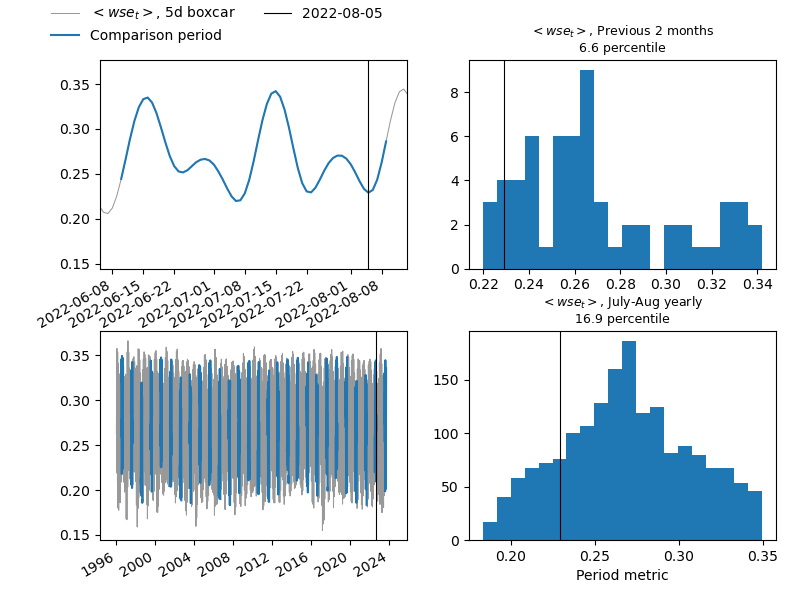

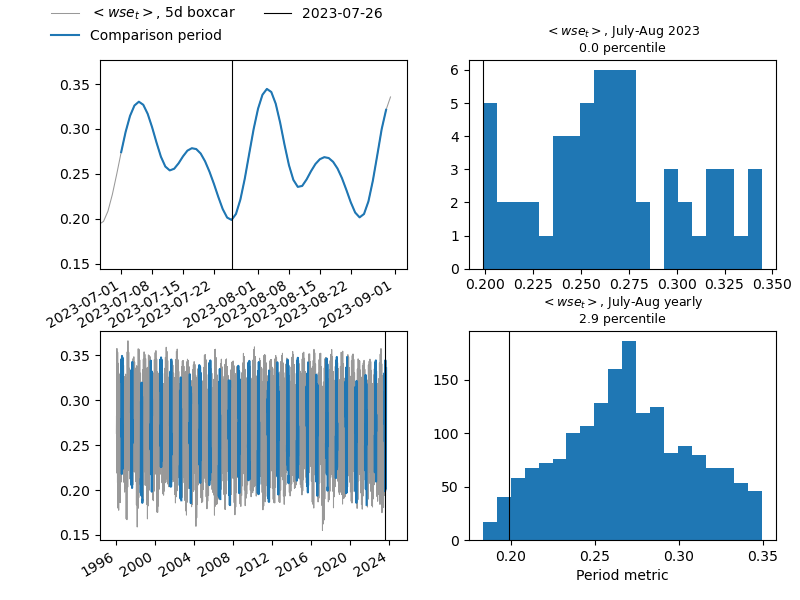

In [127]:
# Combine tides and daylight
# For this I want a measure of tidal currents.
# Could go with harmonics, but that might be too location specific.
# Not sufficient to just use water level directly since I want a 
# measure of mixing.
# Try time derivative of WSE.
# Check against distribution of d WSE/dt along the way.
wse_t=alameda_regular.wse_t

d_wse_rms= filters.lowpass_fir(wse_t**2,winsize=np.timedelta64(60,'h'))**0.5
d_wse_rms.name="$<wse_t>$"    

metric_cdfs(d_wse_rms,bloom_start=np.datetime64("2022-08-05"),periods=periods2022)
metric_cdfs(d_wse_rms,bloom_start=np.datetime64("2023-07-26"),periods=periods2023)
None

Previous 2 months: 63.9 percentile
July-Aug yearly: 70.0 percentile
July-Aug 2023: 96.7 percentile
July-Aug yearly: 98.7 percentile


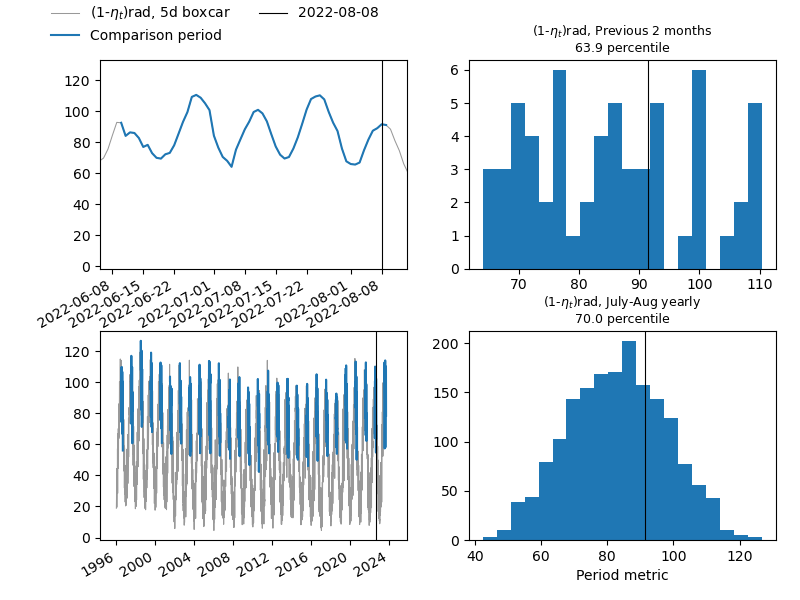

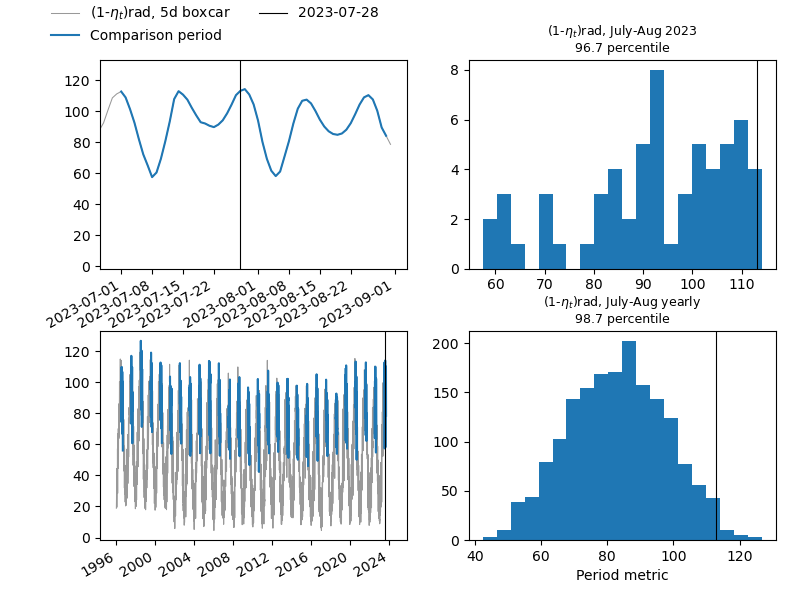

In [157]:
# 0.5 m/h is an energetic tide. Call that the max.
ds=alameda_regular
rad_weighted=(0.5-np.abs(ds['wse_t'])).clip(0) * ds['rad_filled']
rad_weighted.name=r"(1-$\eta_t$)rad"

    
metric_cdfs(rad_weighted,
             bloom_start=np.datetime64("2022-08-08"),periods=periods2022)
metric_cdfs(rad_weighted,
             bloom_start=np.datetime64("2023-07-28"),periods=periods2023)

None

Closer look at Tides $\times$ Solar Radiation
--

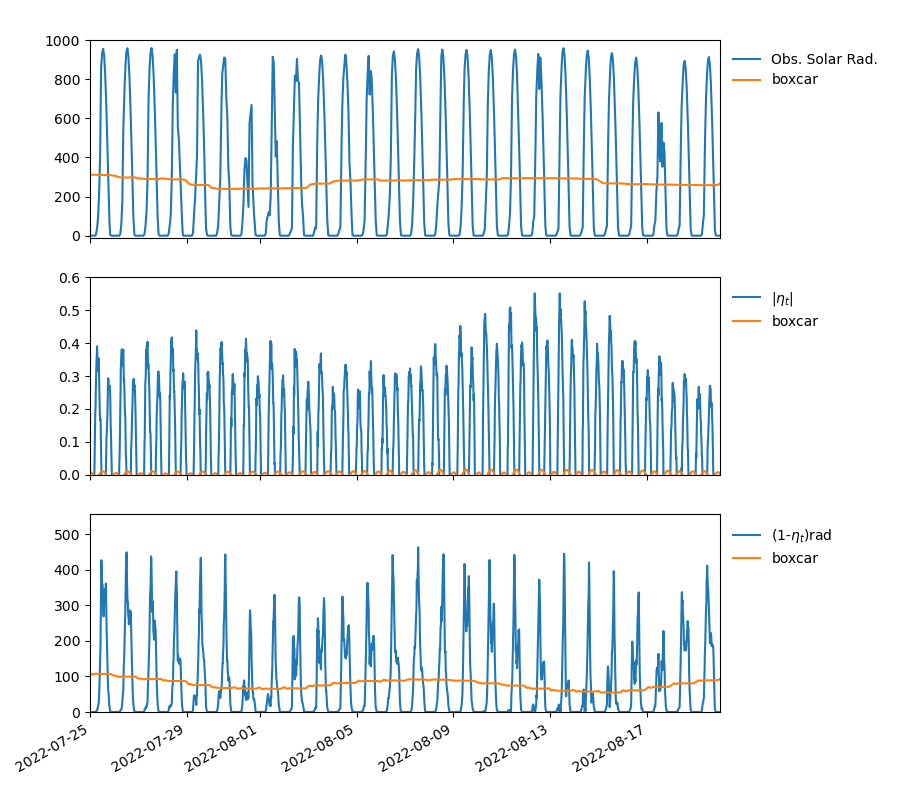

In [137]:
fig,axs=plt.subplots(3,1,sharex=True,figsize=(9,8))
ds=alameda_regular

axs[0].plot(ds.time+utc2pst, ds.cimis_rad,label='Solar Rad.')
axs[0].plot(ds.time+utc2pst, boxcar(ds.cimis_rad),label='boxcar')

axs[1].plot(ds.time+utc2pst, ds.wse_t, label='|$\eta_t|$')
axs[1].plot(ds.time+utc2pst,boxcar(ds.wse_t),label='boxcar')

rad_weighted=(0.5-np.abs(ds['wse_t'])).clip(0) * ds['rad_filled']
rad_weighted.name=r"(1-$\eta_t$)rad"

axs[2].plot(ds.time+utc2pst, rad_weighted, label=rad_weighted.name)
axs[2].plot(ds.time+utc2pst, boxcar(rad_weighted), label='boxcar')

lkw=dict(loc='upper left',bbox_to_anchor=[1,1],frameon=0)
[ax.legend(**lkw) for ax in axs]

axs[0].axis( xmin=np.datetime64("2022-07-25"),
             xmax=np.datetime64("2022-08-20") )
axs[0].axis(ymin=-10,ymax=1000)
axs[1].axis(ymin=0.0,ymax=0.6)
axs[2].axis(ymin=0.0)

fig.autofmt_xdate()
fig.subplots_adjust(top=0.95,right=0.8,left=0.1,bottom=0.11)

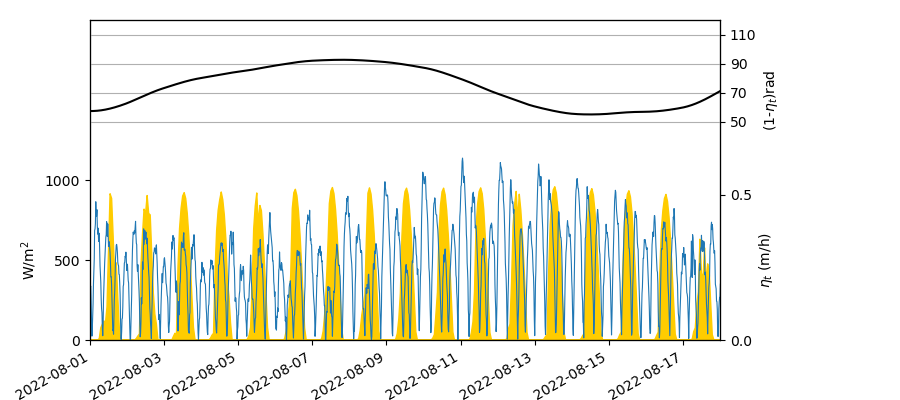

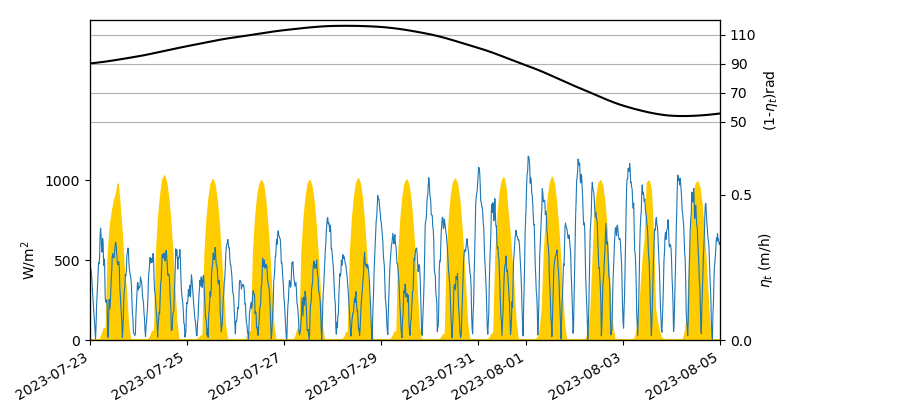

In [158]:
def fig_solar_by_tides(period):
    fig,ax=plt.subplots(figsize=(9,4))
    ds=alameda_regular
    
    def lp_woo(da):
        return filters.lowpass_fir(da,window_of_opportunity)
    
    ax.fill_between(ds.time+utc2pst, 0, ds.rad_filled,color='#ffcc00',label='Solar Rad.')
    
    ax_wse_t=ax.twinx()
    
    ax_wse_t.plot(ds.time+utc2pst, np.abs(ds.wse_t), label='|$\eta_t|$',lw=0.8)
    
    rad_weighted=(0.5-np.abs(ds['wse_t'])).clip(0) * ds['rad_filled']
    rad_weighted.name=r"(1-$\eta_t$)rad"
    
    ax_both = ax.twinx()
    #ax_both.plot(ds.time + utc2pst, boxcar(rad_weighted), label=rad_weighted.name, color='k',lw=1.5)
    ax_both.plot(ds.time + utc2pst, lp_woo(rad_weighted), label=rad_weighted.name, color='k',lw=1.5)
    
    #lkw=dict(loc='upper left',bbox_to_anchor=[1,1],frameon=0)
    #[ax.legend(**lkw) for ax in axs]
    
    ax.axis(xmin=period[0], xmax=period[1] )
    ax.axis(ymin=0,ymax=2000)
    ax.set_yticks([0,500,1000])
    ax.set_ylabel('W/m$^2$',y=0.25)
    ax_wse_t.set_ylabel(r'$\eta_t$ (m/h)',y=0.25)
    ax_wse_t.axis(ymin=0,ymax=1.1)
    ax_wse_t.set_yticks([0,0.5])
    
    ax_both.axis(ymin=-100,ymax=120)
    ax_both.set_yticks([50,70,90,110])
    ax_both.set_ylabel(rad_weighted.name,y=0.75)
    ax_both.grid(axis='y')
    
    fig.autofmt_xdate()
    fig.subplots_adjust(top=0.95,right=0.8,left=0.1,bottom=0.15)
    return fig

fig_solar_by_tides([np.datetime64("2022-08-01"),
                    np.datetime64("2022-08-18") ])
fig_solar_by_tides([np.datetime64("2023-07-23"),
                    np.datetime64("2023-08-05") ])
None

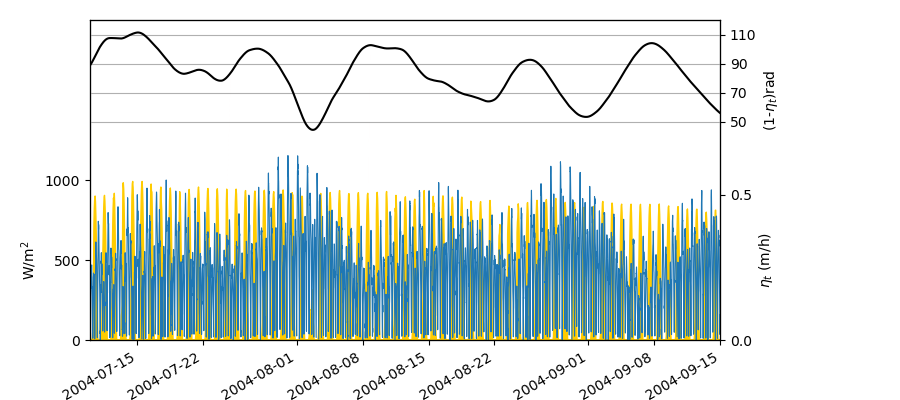

In [163]:
fig_solar_by_tides([np.datetime64("2004-07-10"),
                    np.datetime64("2004-09-15") ])
None

Turbidity
--

In [53]:
# Similar but with SSC.
from stompy.io.local import usgs_nwis
alcatraz_id=374938122251801

alcatraz=usgs_nwis.nwis_dataset(alcatraz_id,
                                start_date=np.datetime64("2010-10-01"),
                                end_date=np.datetime64("2022-10-01"),
                                products=[63680], # Turbidity, FNU.
                                cache_dir='cache')


<IPython.core.display.Javascript object>


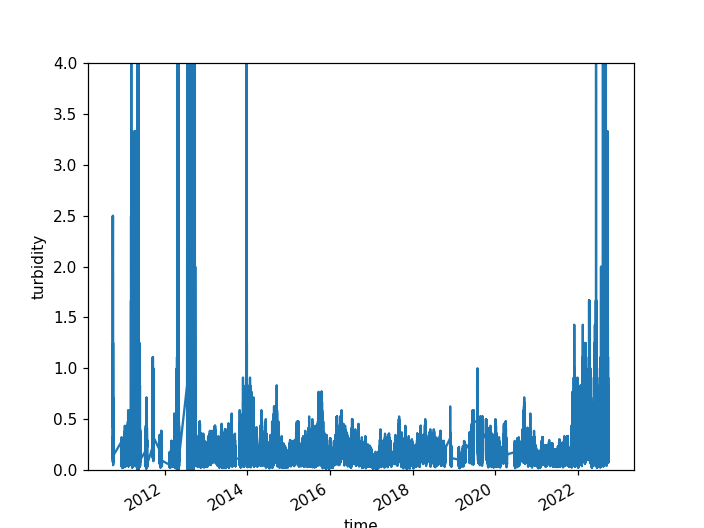

(14663.964583333334, 19482.743749999998, 0.0, 4.0)

In [54]:
fig,ax=plt.subplots()
(1./alcatraz['turbidity']).plot()
ax.axis(ymin=0,ymax=4)

previous month: 0.0 percentile


<IPython.core.display.Javascript object>


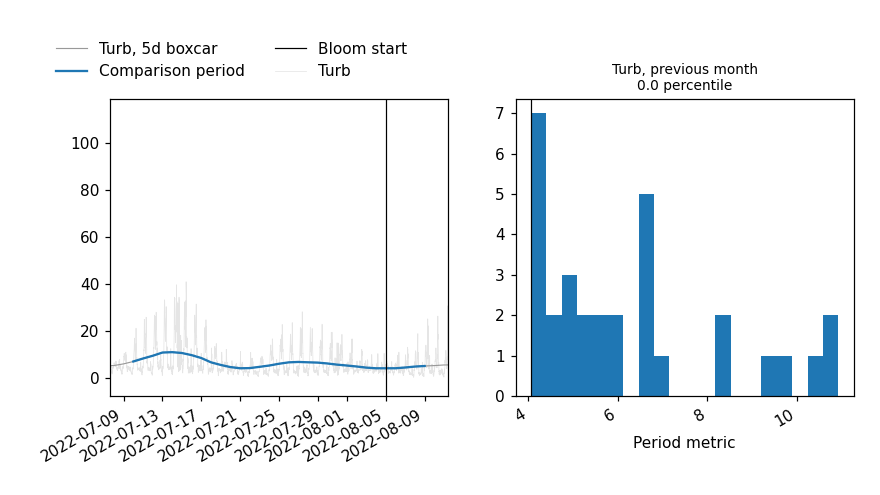

previous 2 months: 3.8 percentile


<IPython.core.display.Javascript object>


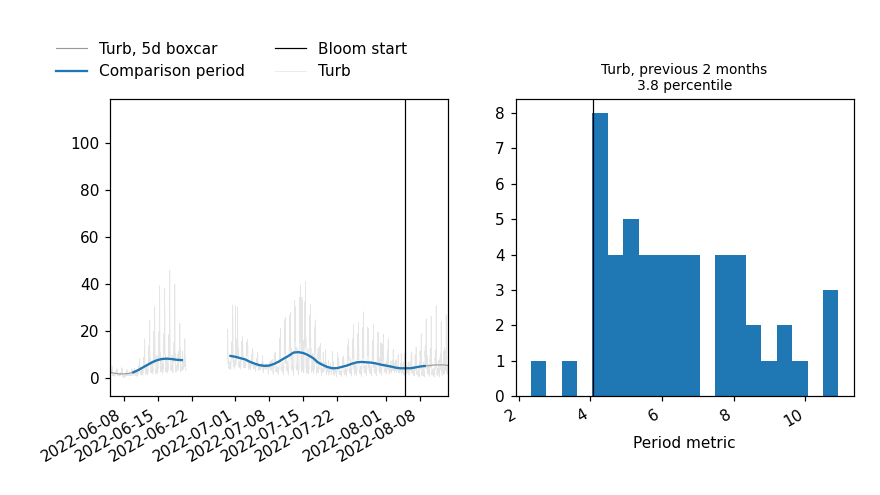

July-Aug yearly: 9.8 percentile


<IPython.core.display.Javascript object>


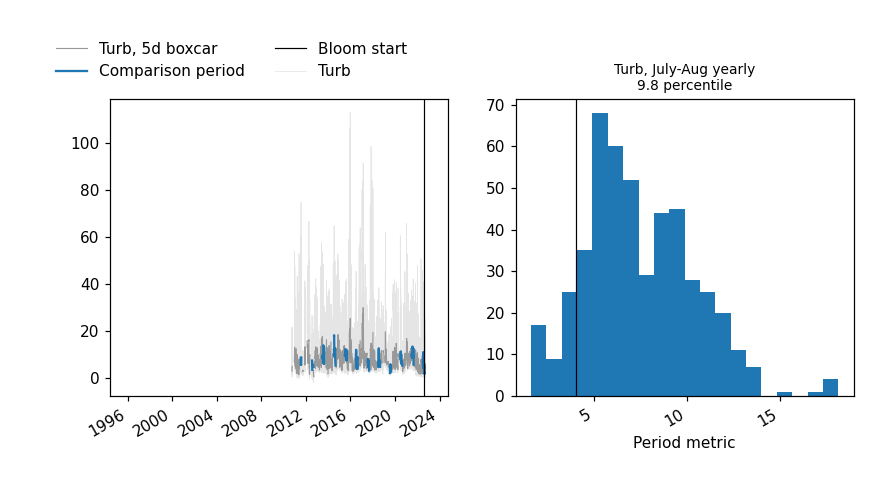

[<Figure size 800x450 with 2 Axes>,
 <Figure size 800x450 with 2 Axes>,
 <Figure size 800x450 with 2 Axes>]

In [56]:
# Get turbidity onto the rms_tide timeline
turb_orig=alcatraz['turbidity']
turb=utils.interp_near(rms_tide.time,
                       turb_orig.time.values, turb_orig.values,
                       max_dx=np.timedelta64(2,'h'))
ds=xr.Dataset()
ds['time']=rms_tide.time
ds['Turb']=('time',),turb

metric_cdfs(ds['Turb'],
            bloom_start=np.datetime64("2022-08-05"),
            show_unfiltered=True)

previous month: 3.2 percentile


<IPython.core.display.Javascript object>


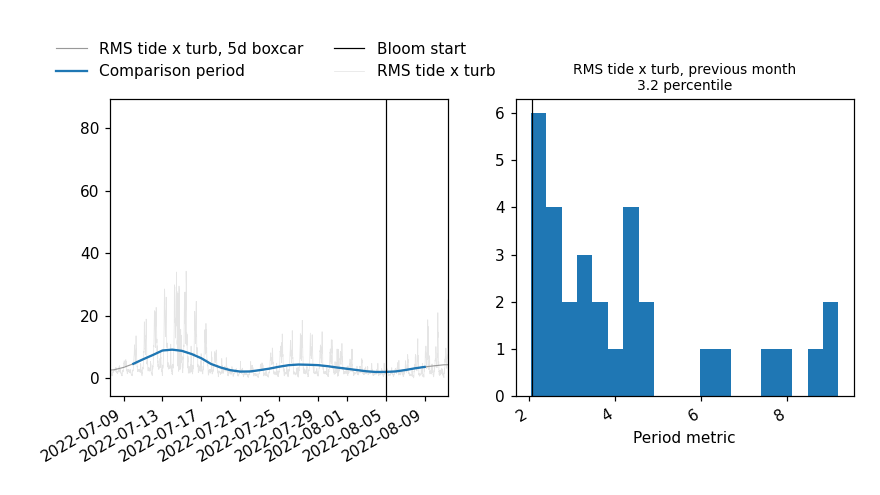

previous 2 months: 3.8 percentile


<IPython.core.display.Javascript object>


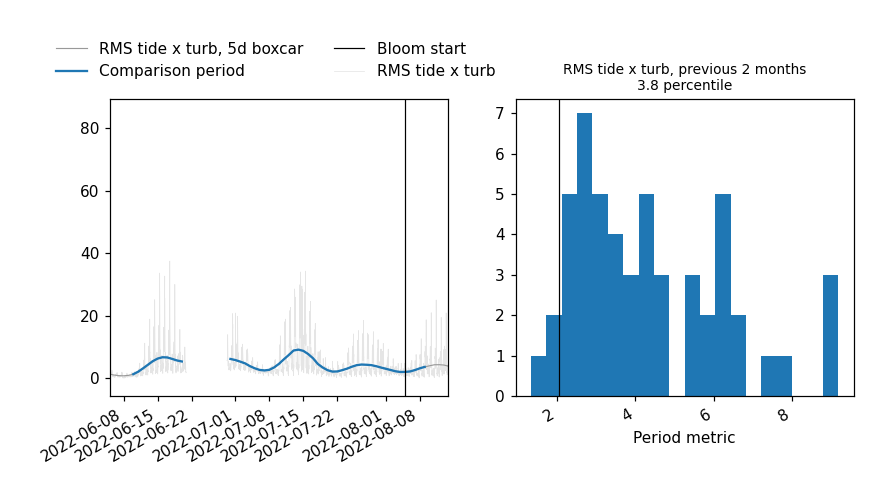

July-Aug yearly: 8.5 percentile


<IPython.core.display.Javascript object>


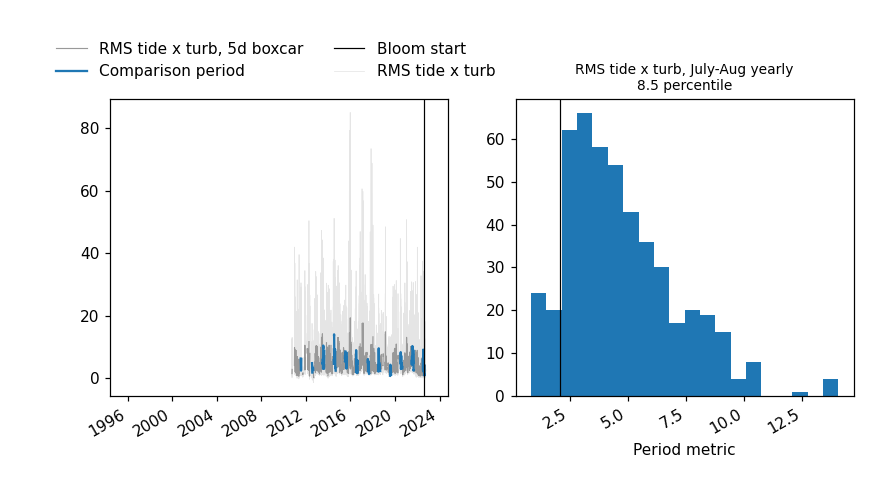

[<Figure size 800x450 with 2 Axes>,
 <Figure size 800x450 with 2 Axes>,
 <Figure size 800x450 with 2 Axes>]

In [58]:
# Combine spring-neap and turbidity

ds=xr.Dataset()
ds['time']=rms_tide.time
ds['Turb']=('time',),turb
ds['RMS tide']=rms_tide
ds['combined']=ds.Turb * ds['RMS tide']

da=ds.combined
da.name="RMS tide x turb"
metric_cdfs(da,
            bloom_start=np.datetime64("2022-08-05"),
            show_unfiltered=True)

In [59]:
alameda_regular

<xarray.Dataset>
Dimensions:            (time: 943776)
Coordinates:
  * time               (time) datetime64[ns] 1996-01-01 ... 2022-11-30T23:45:00
    station            <U7 '9414750'
Data variables:
    name               object 'Alameda'
    lat                float64 37.77
    lon                float64 -122.3
    water_level        (time) float64 0.08133 0.1215 0.172 ... 1.368 1.426 1.48
    wind_speed         (time) float64 nan nan nan nan nan ... nan nan nan nan
    wind_direction     (time) float64 nan nan nan nan nan ... nan nan nan nan
    wind_gust          (time) float64 nan nan nan nan nan ... nan nan nan nan
    water_temperature  (time) float64 12.7 nan nan nan 12.7 ... nan nan nan nan
    air_temperature    (time) float64 nan nan nan nan nan ... nan nan nan nan

previous month: 74.2 percentile


<IPython.core.display.Javascript object>


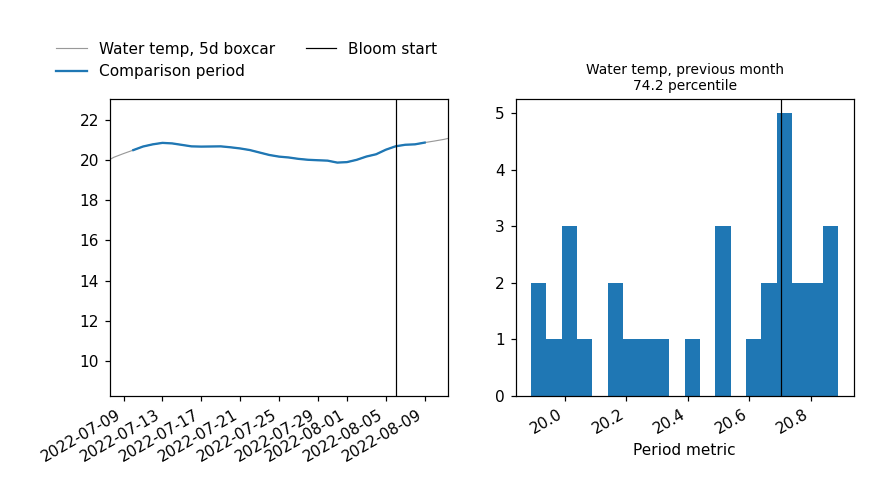

previous 2 months: 65.6 percentile


<IPython.core.display.Javascript object>


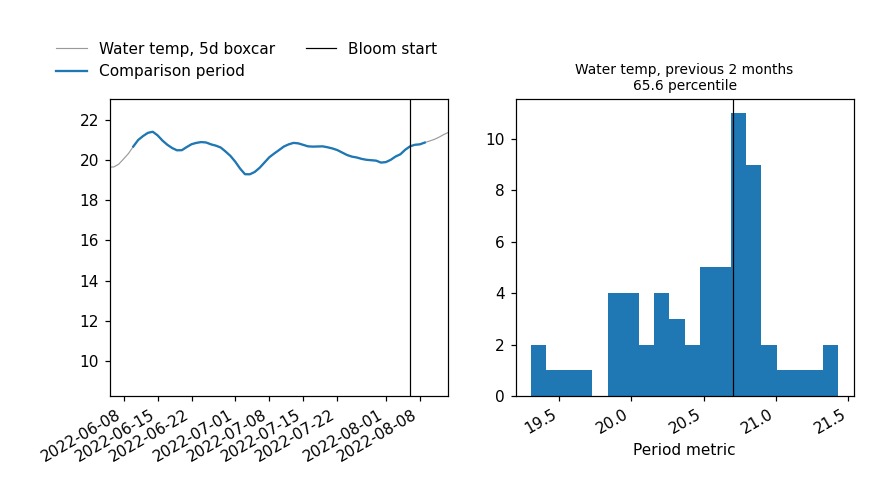

July-Aug yearly: 70.0 percentile


<IPython.core.display.Javascript object>


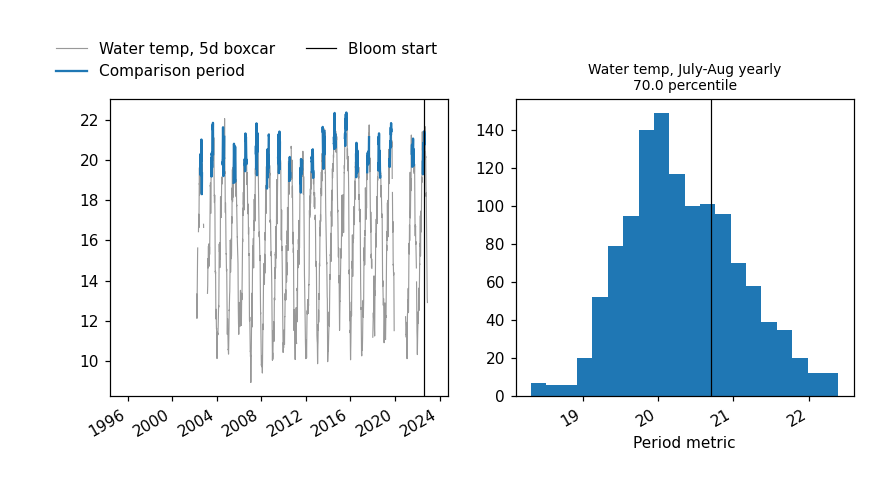

[<Figure size 800x450 with 2 Axes>,
 <Figure size 800x450 with 2 Axes>,
 <Figure size 800x450 with 2 Axes>]

In [64]:
# Temperature
metric_cdfs(alameda_regular['water_temperature'].rename('Water temp'),
            bloom_start=np.datetime64("2022-08-06"))

previous month: 87.1 percentile


<IPython.core.display.Javascript object>


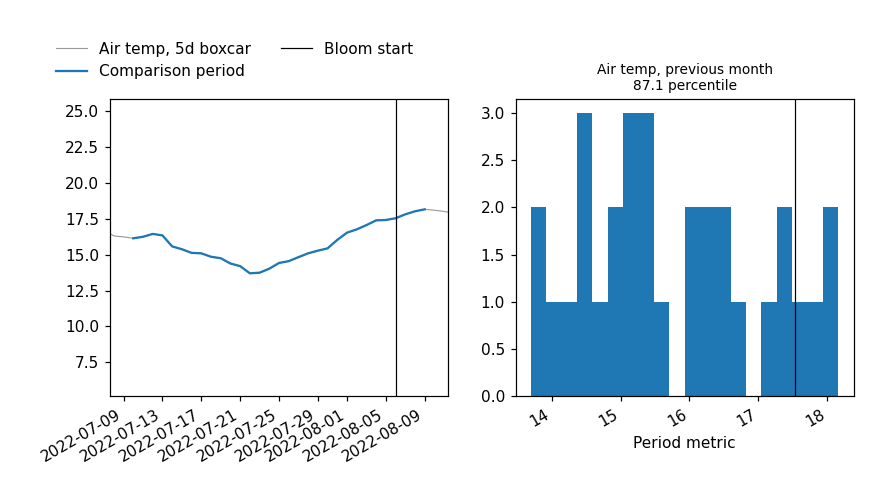

previous 2 months: 80.3 percentile


<IPython.core.display.Javascript object>


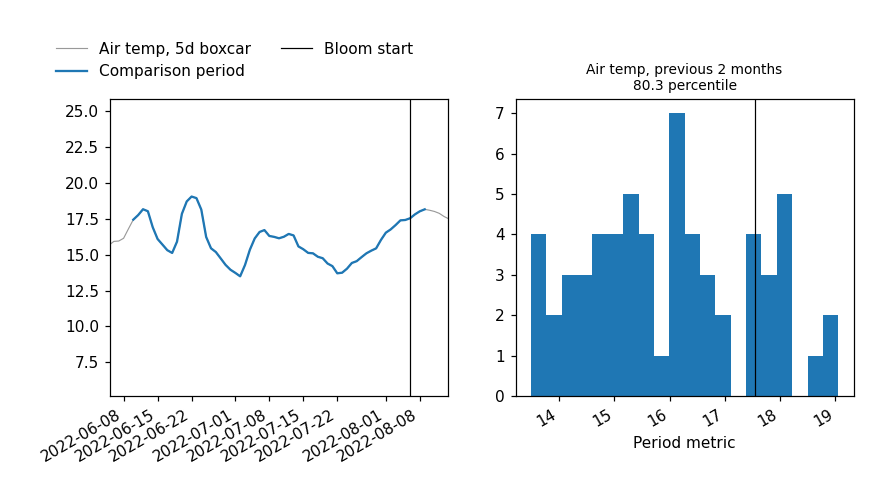

July-Aug yearly: 82.9 percentile


<IPython.core.display.Javascript object>


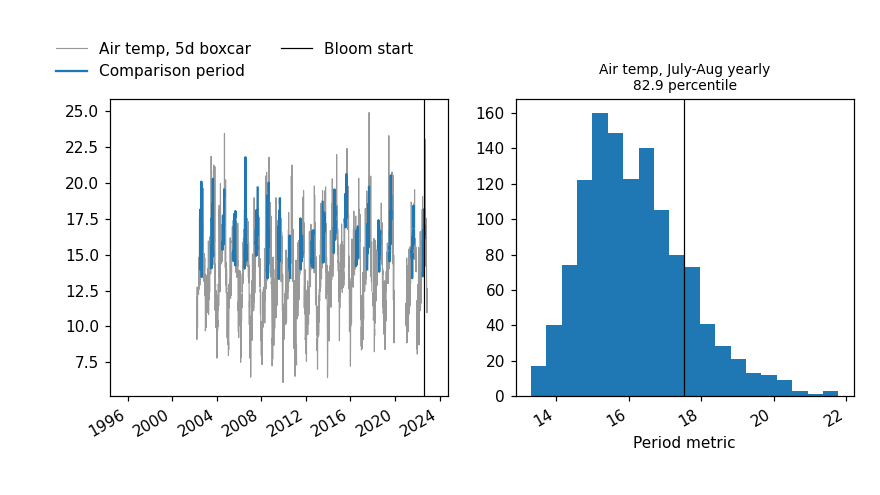

[<Figure size 800x450 with 2 Axes>,
 <Figure size 800x450 with 2 Axes>,
 <Figure size 800x450 with 2 Axes>]

In [65]:
# Temperature
metric_cdfs(alameda_regular['air_temperature'].rename('Air temp'),
            bloom_start=np.datetime64("2022-08-06"))

previous month: 96.8 percentile


/tmp/ipykernel_3679992/2983690357.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,axs=plt.subplots(1,2,figsize=(8,4.5))


<IPython.core.display.Javascript object>


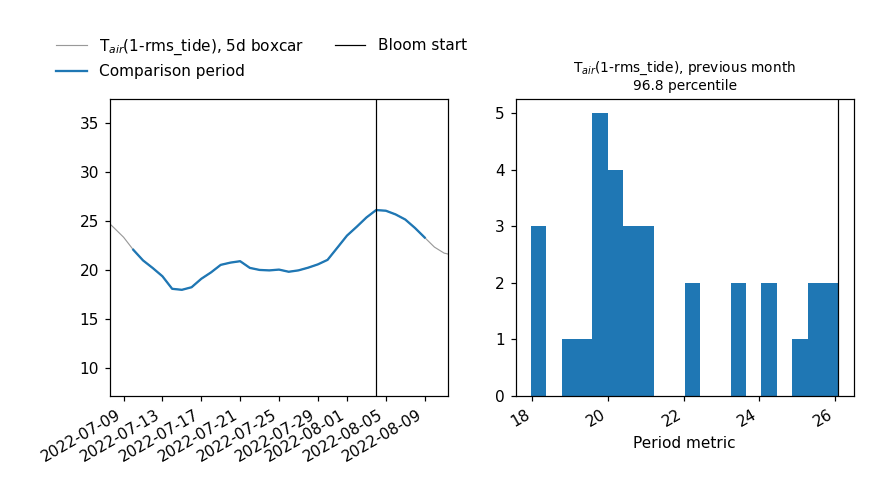

previous 2 months: 91.8 percentile


<IPython.core.display.Javascript object>


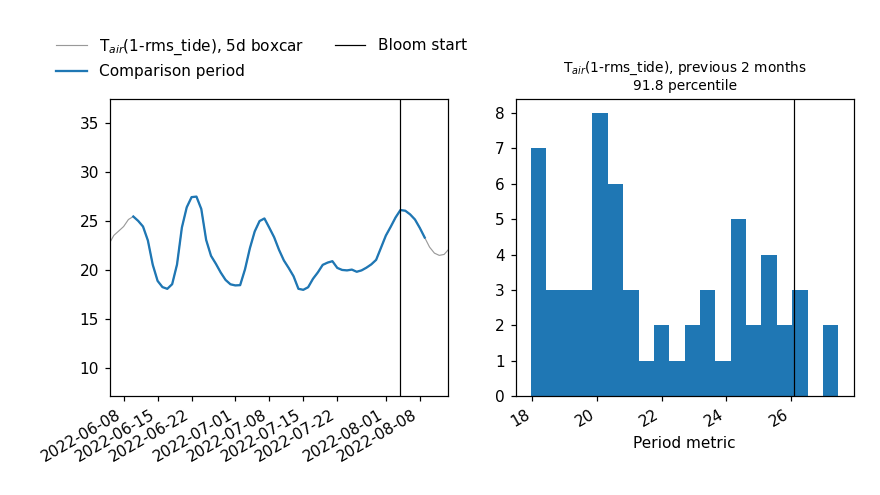

July-Aug yearly: 90.4 percentile


<IPython.core.display.Javascript object>


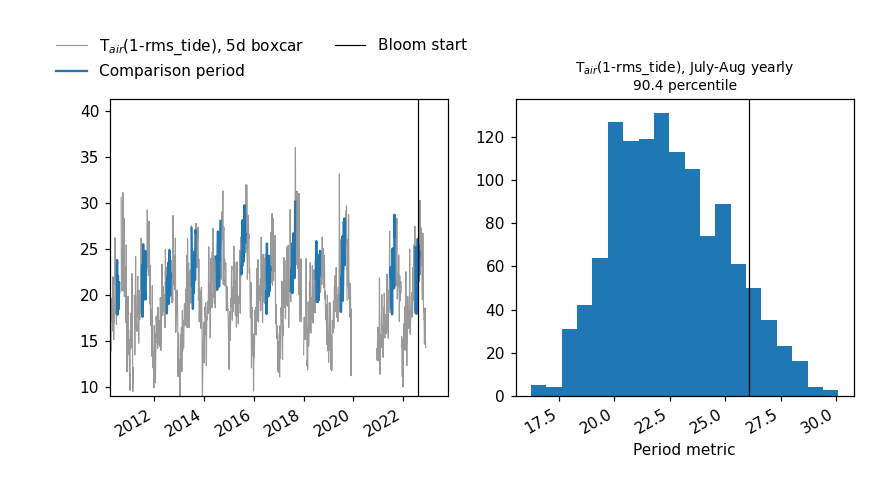

[<Figure size 800x450 with 2 Axes>,
 <Figure size 800x450 with 2 Axes>,
 <Figure size 800x450 with 2 Axes>]

In [69]:
# Air temperature and spring/neap
tide_and_temp=alameda_regular['air_temperature']*(2-rms_tide).clip(0)
tide_and_temp.name="T$_{air}$(1-rms_tide)"
metric_cdfs(tide_and_temp,
            bloom_start=np.datetime64("2022-08-04"))

previous month: 93.5 percentile


<IPython.core.display.Javascript object>


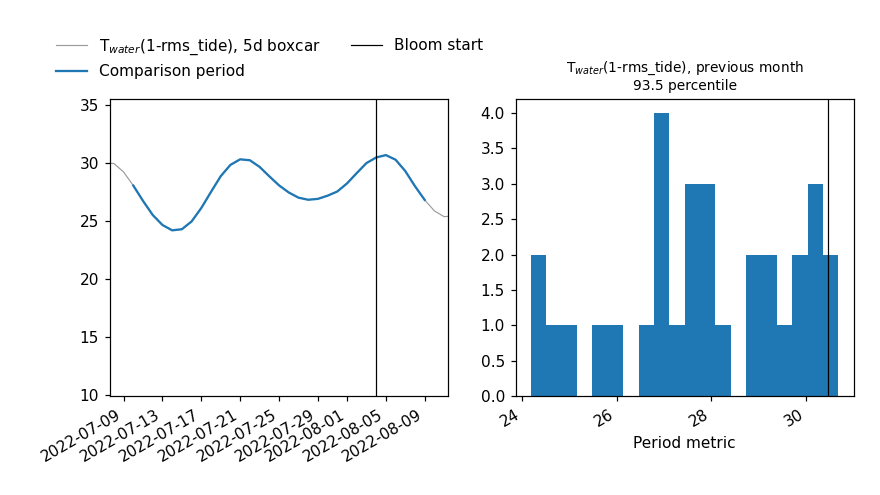

previous 2 months: 96.7 percentile


<IPython.core.display.Javascript object>


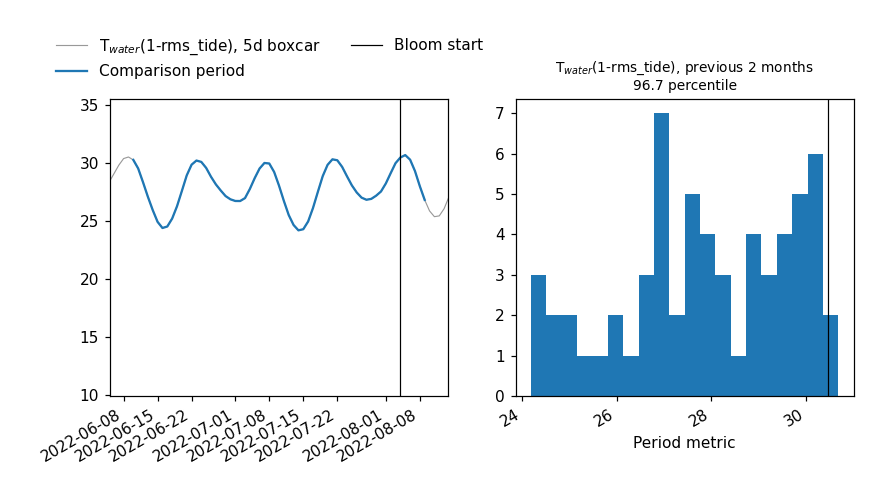

July-Aug yearly: 83.1 percentile


<IPython.core.display.Javascript object>


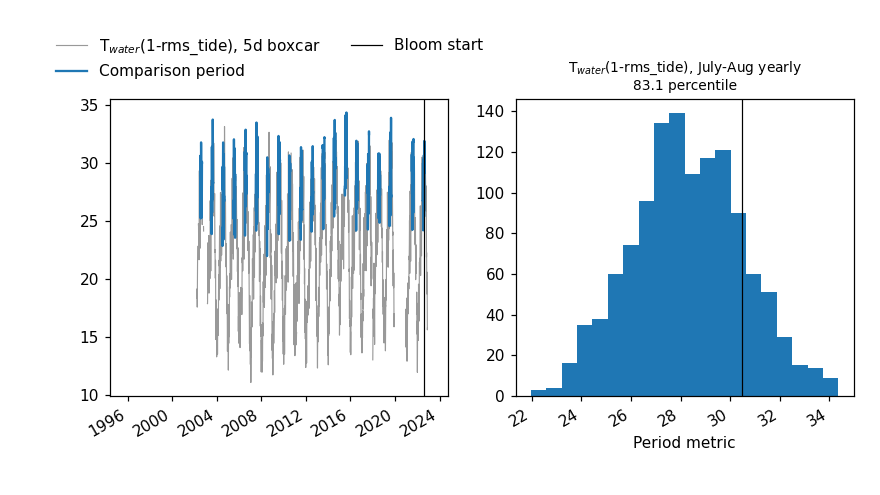

[<Figure size 800x450 with 2 Axes>,
 <Figure size 800x450 with 2 Axes>,
 <Figure size 800x450 with 2 Axes>]

In [67]:
# Water temperature and spring/neap
tide_and_temp=alameda_regular['water_temperature']*(2-rms_tide).clip(0)
tide_and_temp.name="T$_{water}$(1-rms_tide)"
metric_cdfs(tide_and_temp,
            bloom_start=np.datetime64("2022-08-04"))